# Influence propagation. Threshold Models

During this lab we will consider simulation of influence propagation through network and see what can thread its spread.

In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Linear Threshold Model 

To recall the setting:
* Influence spread iteratively given some initially activated nodes (adopters)
* Each node $v_i$ have an activation threshold $\theta_i \in [0, 1]$
* If fraction of "activated" neighbours is greater than $\theta_i$, node $v_i$ also become activated

This information (or behaviour) spreading process is also called cascade. If after some number of iterations the whole network became activated we have a **complete cascade**.

In [2]:
# Some initials
G = nx.erdos_renyi_graph(10, 0.4)
pos = nx.spring_layout(G)
A = np.array(nx.adjacency_matrix(G).todense())
n = A.shape[0]

theta = 2.0/5


idx = [0,1,2]
initActive = np.zeros((n,), dtype=bool)
initActive[idx] = 1

In [3]:
# Influence propagation simulation
def InfluenceProp(A, intiActive, theta, itersNum = np.inf):
    deg = np.sum(A,axis=0, dtype=float)
    i = 1 # iteration
    resActive = initActive.copy()    
    while i < itersNum:
        i+=1

        # currently inactive nodes
        inactiveId = np.where(resActive == 0)[0]    
        # activated nodes
        idx = np.sum(A[np.ix_(resActive==1, resActive==0)], axis=0) / deg[resActive==0] > theta
        if np.any(idx):
            resActive[inactiveId[idx]] = 1
        else:
            break

    return resActive

# Demonstration
def ShowIteration(G, initActive, resultActive, pos):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    nx.draw(G, pos=pos,
            nodelist=np.where(initActive)[0].tolist(),
            node_color = 'r')
    nx.draw(G, pos=pos,
            nodelist=np.where(1-initActive)[0].tolist(),
            node_color = 'b')

    plt.subplot(1,2,2)
    nx.draw(G, pos=pos,
            nodelist=np.where(resultActive)[0].tolist(),
            node_color = 'r')
    nx.draw(G, pos=pos,
            nodelist=np.where(1-resultActive)[0].tolist(),
            node_color = 'b')

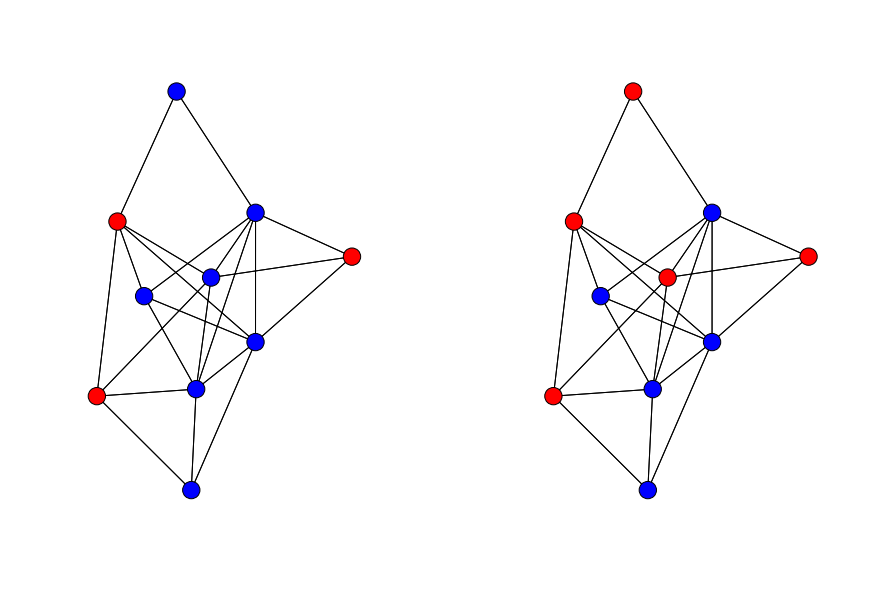

In [6]:
# Run 
resultActive = InfluenceProp(A, initActive, theta, itersNum = 2)

# Look 
ShowIteration(G, initActive, resultActive, pos)

## Clusters 

Lets call a cluster with density $p$ a set of nodes s.t. each node has at least $p$ fraction of its neighbours in the set. And it turn out that then only thing that can stop cascades are clusters, particularly:


*Consider a network with a threshold of $\theta$ a set of initialy activated nodes*
1. *If the remaining network contains a cluster of density greater than $1 − \theta$, then the set of initial adopters **will not** cause a complete cascade.*
2. *Whenever a set of initial adopters does not cause a complete cascade with threshold $\theta$, the remaining network must contain a cluster of density greater than $1 − \theta$.*


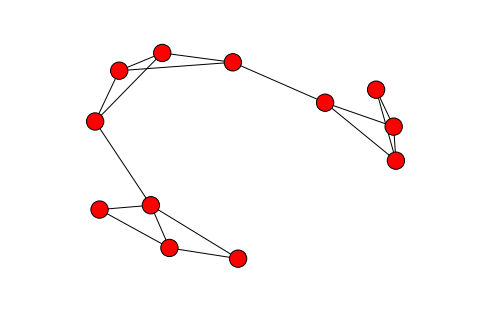

In [7]:
# Illustrative Example

G = nx.cycle_graph(4)
arrG = [G]*3
G = reduce(lambda g1,g2: nx.disjoint_union(g1,g2), arrG)
edList = [(0,2),(4,6),(9,11)] 
G.add_edges_from(edList)
edList = [(3,5),(4,7),(7,11)]
G.add_edges_from(edList)
nx.draw_spring(G)

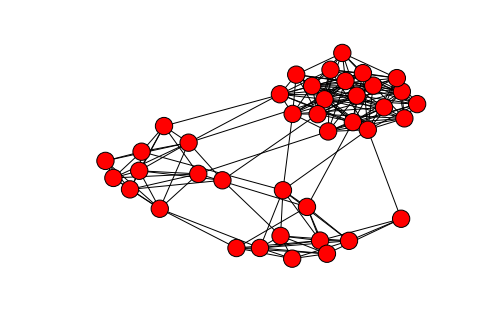

In [10]:
# Randomized Option. (may not end well..)

arrG = [nx.erdos_renyi_graph(10, 0.6)]* 2
arrG.append(nx.erdos_renyi_graph(20, 0.6))
G = reduce(lambda g1,g2: nx.disjoint_union(g1,g2), arrG)
# nx.draw(G)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(10,20,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(10,20,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)

In [17]:
A = np.array(nx.adjacency_matrix(G).todense())
n = A.shape[0]

theta = 1.0/10

idx = range(0, 5)
initActive = np.zeros((n,), dtype=bool)
initActive[idx] = 1

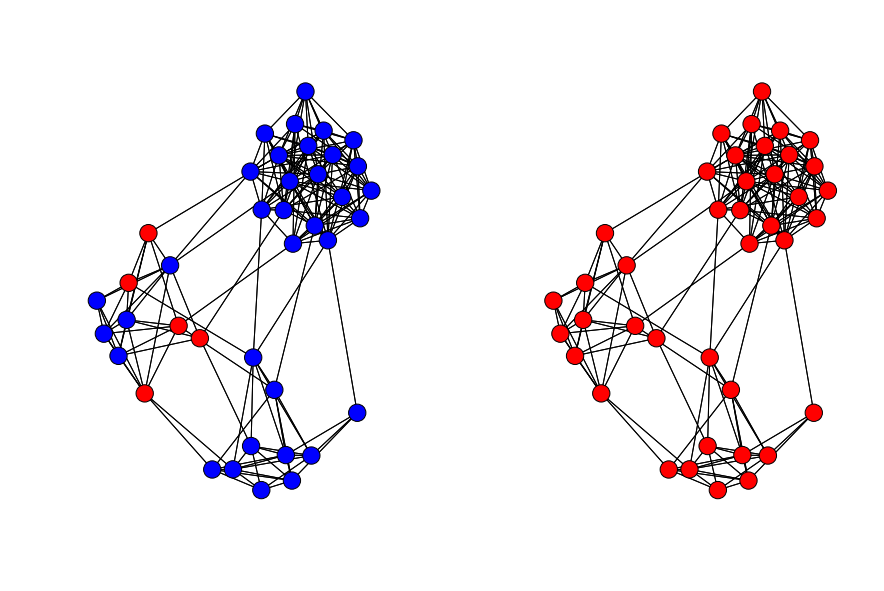

In [18]:
# Run
resultActive = InfluenceProp(A, initActive, theta)

# Look
ShowIteration(G, initActive, resultActive, pos)

## Note on Greedy Algorithm for Threshold Models

Let $S$ be a target nodes (initally activated set of nodes). $f(S)$ is a number of activated nodes as propagation stops

**Good news:** <br/>
We have greedy algorithm for submodular functions that gives constant factor approximation of optimal solution: $$f(S) \geq(1 - \frac{1}{1-e})f(S^*)$$
**Bad news:** <br/>
1. Not clear how to compute $f(S)$ in threshold and cascade models
2. Even if we know we need to speed-up the process

**Solutions:**
1. Instead of computing the exact value of $f(S)$ we can estimate it via numerous simulation of Independent Cascade process (provides the same results)
2. 'Lazy' greedy algorithm uses the fact that if $A \subseteq B$ then:
$$ f(s \cup A) - f(A) \geq f(s \cup B) - f(B) $$
In other words: as the set increases its marginal gain can only decrease. And in fact it won't decrease drammatically, so essentially we need to keep track of only top of the list.

So the idea is
* Keep ordered list of marginal gains from previous iterations
* Re-evaluate marginal gains only for top of elements
* Resort and pick $\arg\max$